In [50]:
import os
import re
import cv2
import time
import shutil
import zipfile
import urllib.request
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D 

In [4]:
# download soil_photos.zip
file = 'soil_photos.zip'
url = 'http://apmonitor.com/pds/uploads/Main/'+file
urllib.request.urlretrieve(url, file)

('soil_photos.zip', <http.client.HTTPMessage at 0x2718bf8c4f0>)

In [5]:
# extract archive and remove soil_photos.zip
with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall('./')
os.remove(file)

In [6]:
# Initiate data processing tools
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

In [7]:
training_data_directory = 'train'
test_data_directory = 'test'

In [8]:
# Load data into Python
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 75 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [9]:
# choose model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs = 20
MODEL_NAME = 'soil'

In [10]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(3))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

Epoch 1/20
3/3 [==============================] - 7s 2s/step - loss: 3.6015 - accuracy: 0.2667 - val_loss: 1.1951 - val_accuracy: 0.3333
Epoch 2/20
3/3 [==============================] - 4s 1s/step - loss: 1.1157 - accuracy: 0.4000 - val_loss: 1.1170 - val_accuracy: 0.3333
Epoch 3/20
3/3 [==============================] - 5s 1s/step - loss: 1.1160 - accuracy: 0.3333 - val_loss: 1.1449 - val_accuracy: 0.3333
Epoch 4/20
3/3 [==============================] - 4s 1s/step - loss: 1.0144 - accuracy: 0.2800 - val_loss: 1.0800 - val_accuracy: 0.4000
Epoch 5/20
3/3 [==============================] - 4s 2s/step - loss: 0.9744 - accuracy: 0.3467 - val_loss: 1.2186 - val_accuracy: 0.3333
Epoch 6/20
3/3 [==============================] - 4s 1s/step - loss: 0.8861 - accuracy: 0.5600 - val_loss: 0.9560 - val_accuracy: 0.7333
Epoch 7/20
3/3 [==============================] - 4s 1s/step - loss: 0.8771 - accuracy: 0.5733 - val_loss: 1.3233 - val_accuracy: 0.4000
Epoch 8/20
3/3 [=========================

In [11]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)
    
    class_ = ["Gravel", "Sand", "Silt"] # possible output values
    predicted_value = class_[model.predict(img_batch).argmax()]
    true_value = re.search(r'(Gravel)|(Sand)|(Silt)', image_fp)[0]
    
    out = f"""Predicted Soil Type: {predicted_value}
    True Soil Type: {true_value}
    Correct?: {predicted_value == true_value}"""
    
    return out

1/1 [==============================] - 0s 184ms/step
Predicted Soil Type: Sand
    True Soil Type: Sand
    Correct?: True


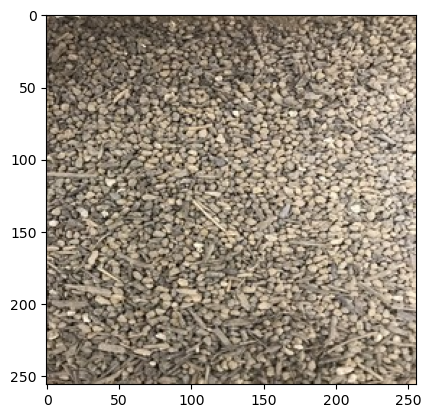

In [12]:
test_image_filepath = test_data_directory + r'/Sand/0.jpg'
print(make_prediction(test_image_filepath))

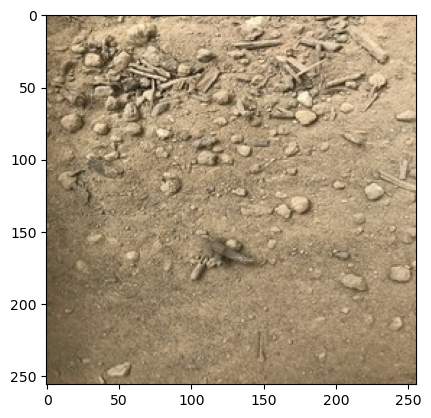

In [13]:
percentage_photo = test_data_directory + r"/Silt/5.jpg"
im = cv2.imread(percentage_photo) # load image
plt.imshow(im[:,:,[2,1,0]])

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv('yield_df.csv')

In [16]:
df.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [17]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [18]:
df.shape

(28242, 7)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.5+ MB


In [20]:
df.isnull().sum()

Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

In [21]:
df.duplicated().sum()

2310

In [22]:
df.drop_duplicates(inplace=True)

In [23]:
df.duplicated().sum()

0

Transforming average_rain_fall_mm_per_year

In [24]:
def isStr(obj):
    try:
        float(obj)
        return False
    except:
        return True
to_drop = df[df['average_rain_fall_mm_per_year'].apply(isStr)].index

In [25]:
df = df.drop(to_drop)

In [26]:
df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [27]:
df['average_rain_fall_mm_per_year'] = df['average_rain_fall_mm_per_year'].astype(np.float64)

In [28]:
len(df['Area'].unique())

101

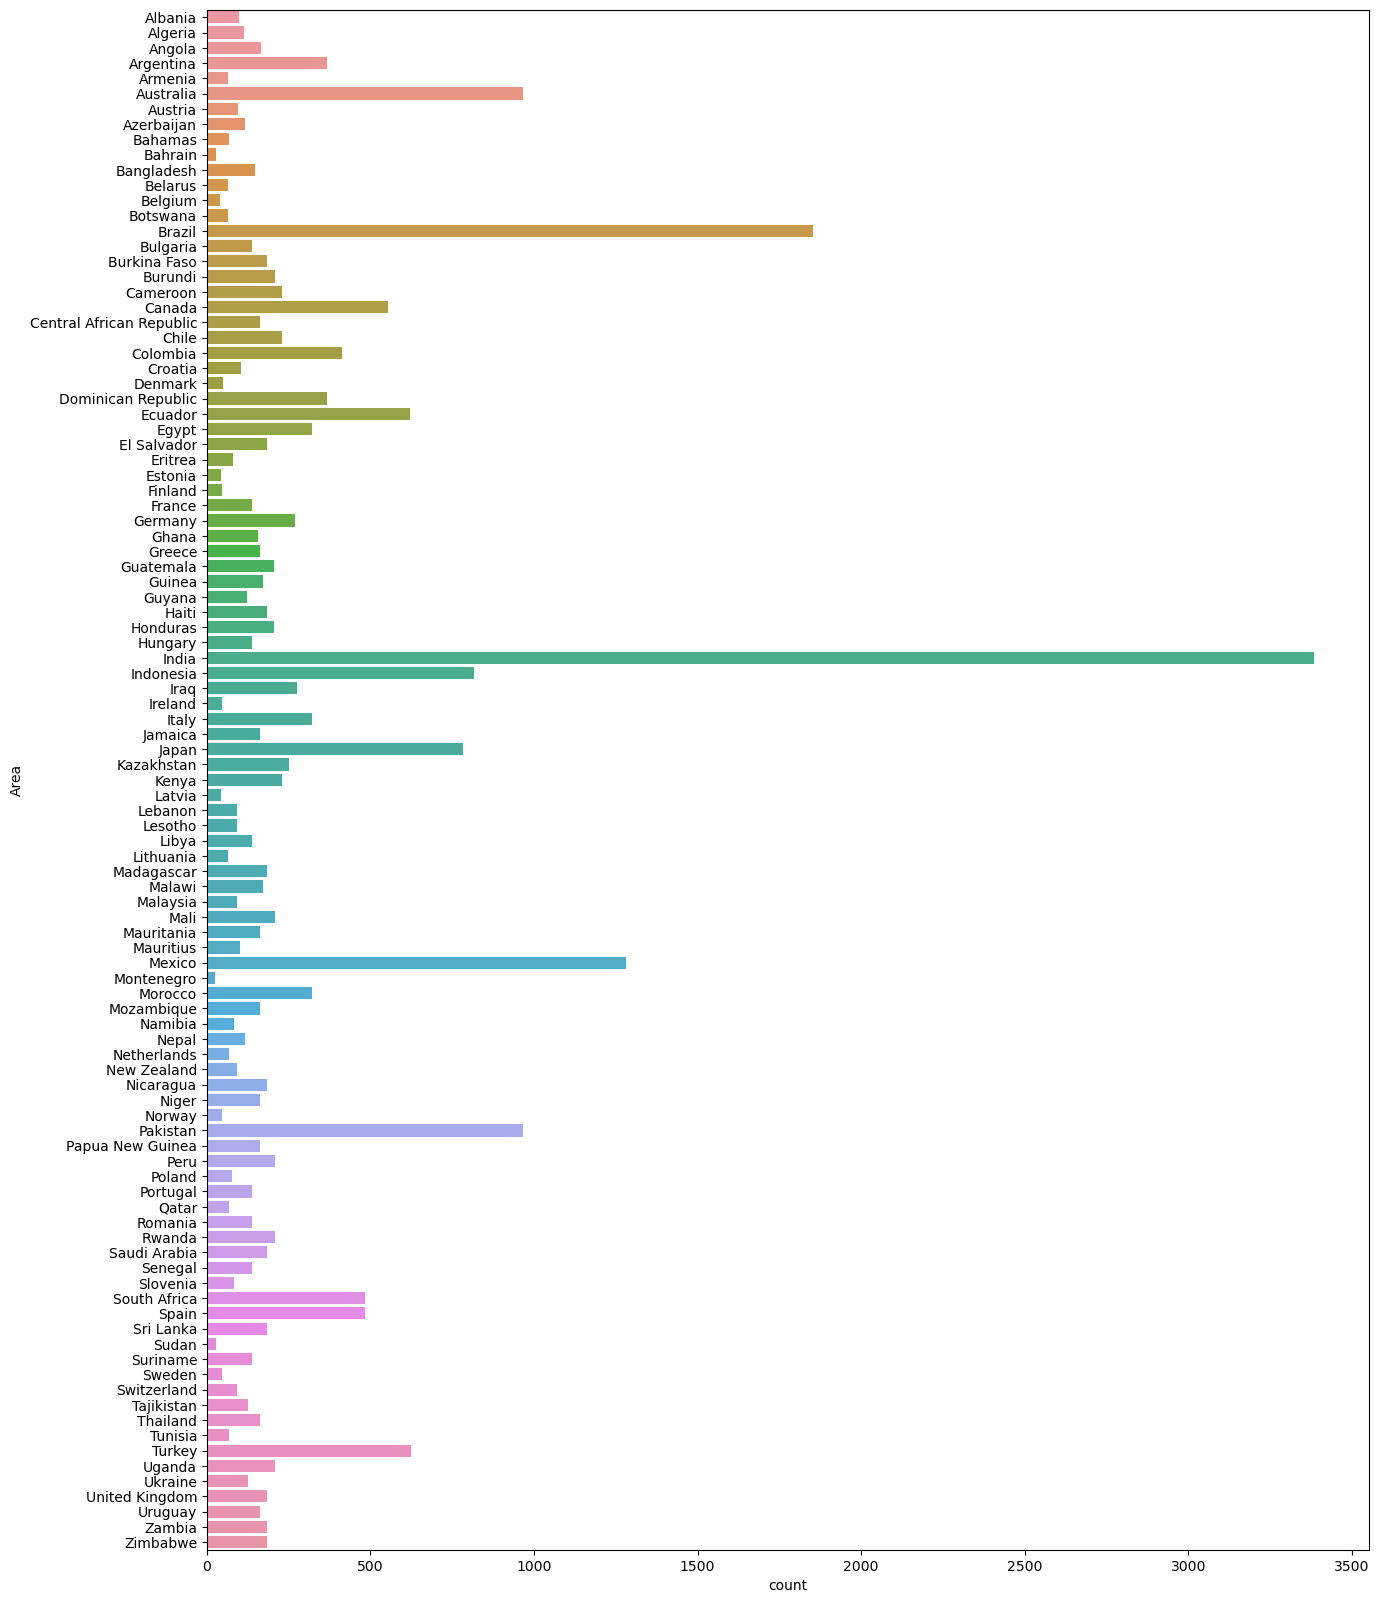

In [29]:
plt.figure(figsize=(15,20))
sns.countplot(y=df['Area'])
plt.show()

In [30]:
(df['Area'].value_counts() < 500).sum()

91

In [31]:
country = df['Area'].unique()
yield_per_country = []
for state in country:
    yield_per_country.append(df[df['Area']==state]['hg/ha_yield'].sum())

In [32]:
df['hg/ha_yield'].sum()

1996196943

In [33]:
yield_per_country

[5711536,
 6711464,
 5722563,
 32864032,
 4524100,
 109111062,
 10852258,
 4608380,
 4384717,
 4443889,
 7720159,
 4704812,
 8442270,
 470651,
 136340329,
 6263075,
 6083337,
 7031146,
 10717883,
 34706922,
 4255627,
 20561214,
 26927138,
 6083167,
 10701651,
 25312166,
 21315591,
 36828848,
 16855944,
 1452416,
 3595638,
 6210668,
 15790618,
 38780463,
 9260371,
 14571925,
 16508723,
 7975743,
 8361103,
 8619194,
 10920131,
 8824110,
 274219558,
 68067328,
 10984722,
 9104030,
 32280700,
 19698007,
 100924145,
 9965212,
 14391737,
 3698588,
 6956804,
 4258932,
 9016288,
 4174348,
 6103523,
 8346715,
 7934982,
 15106720,
 4465841,
 12684212,
 113698872,
 1645100,
 22173010,
 6964027,
 3165475,
 4113713,
 14086433,
 17657728,
 12819227,
 12316327,
 6721305,
 49264956,
 10729929,
 15201910,
 6564711,
 12154347,
 5995626,
 6006156,
 7741053,
 15171886,
 10342677,
 7197013,
 30999849,
 46773540,
 11217741,
 1896346,
 14786468,
 8620653,
 13336346,
 6295210,
 9511720,
 3724246,
 52263950,
 

<Axes: >

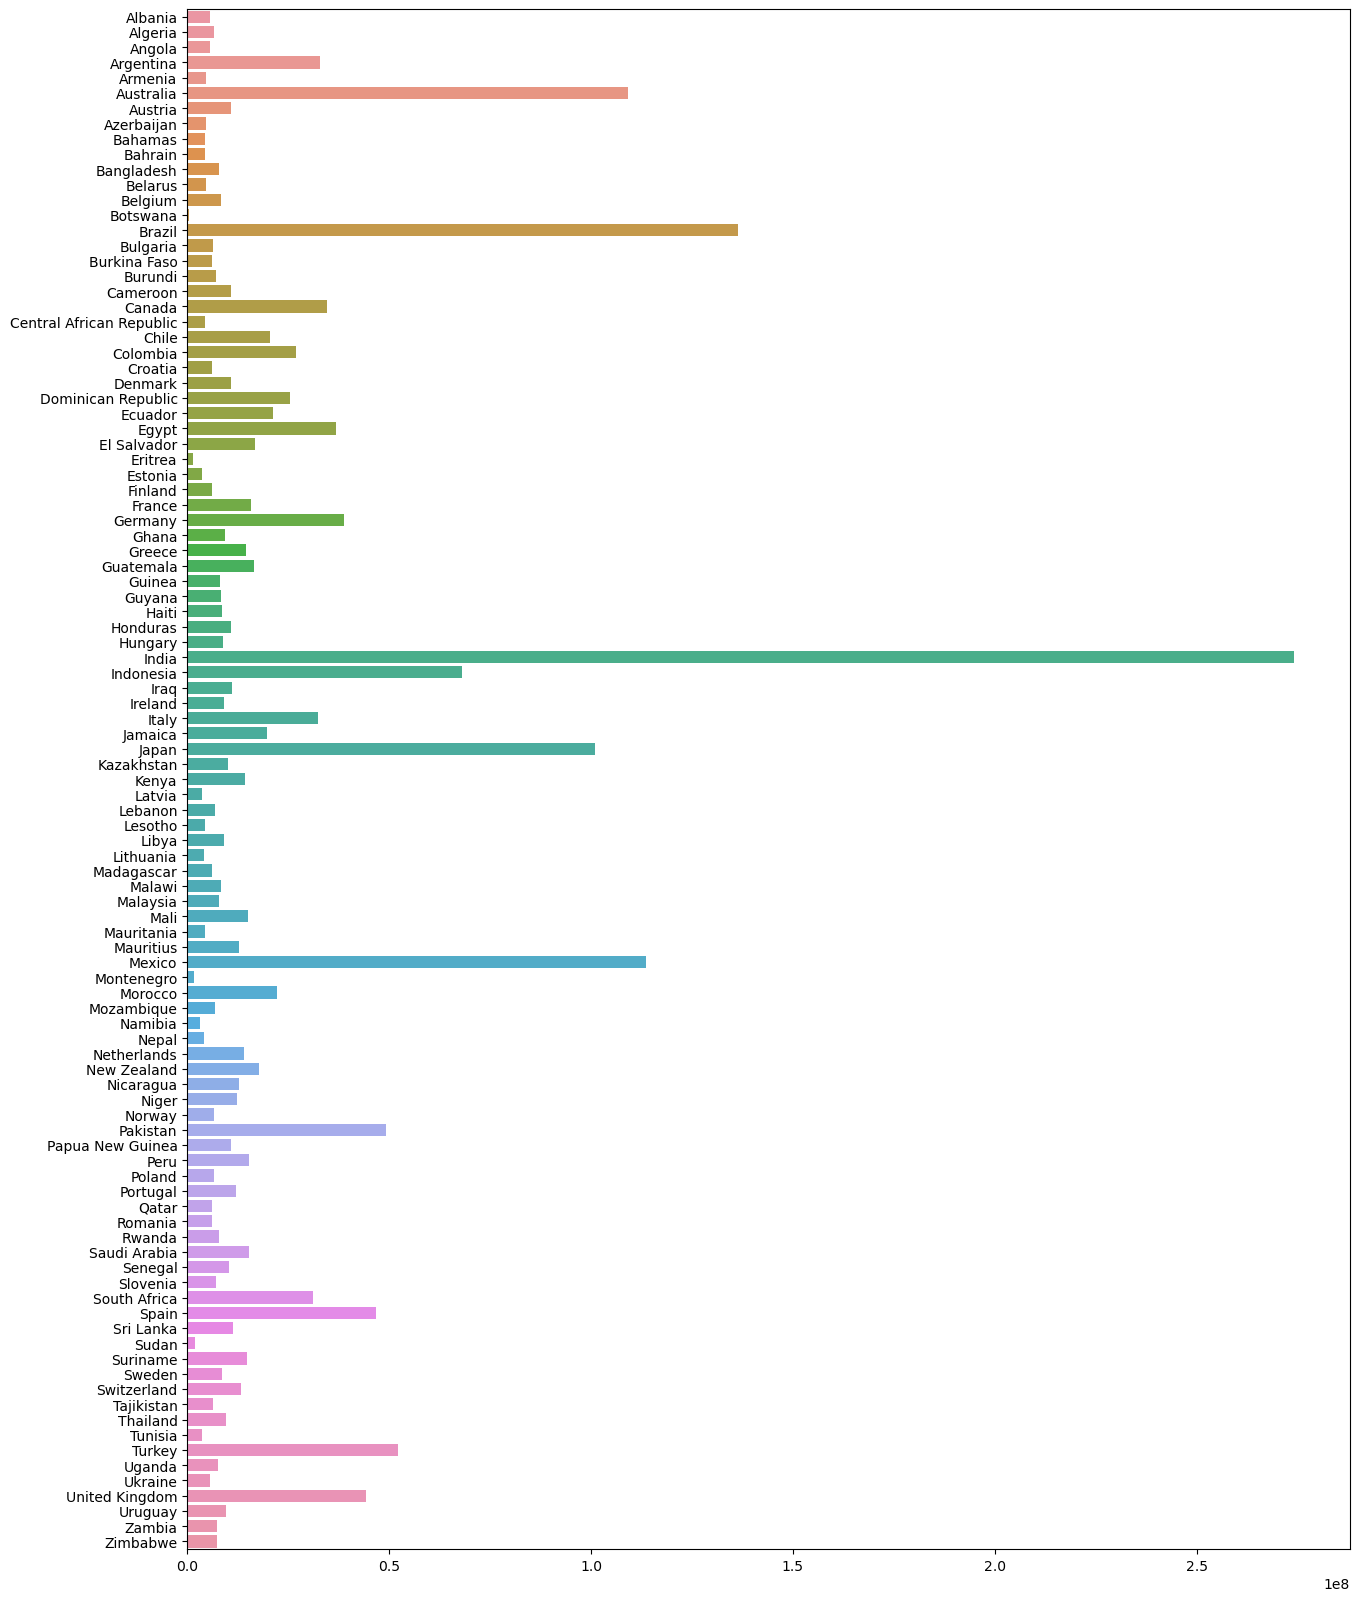

In [34]:
plt.figure(figsize=(15, 20))
sns.barplot(y=country, x=yield_per_country)

Graph Frequency vs Item

<Axes: xlabel='count', ylabel='Item'>

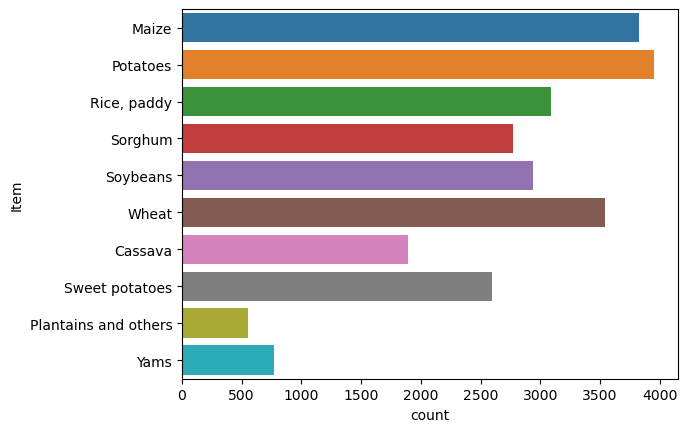

In [35]:
sns.countplot(y=df['Item'])

Yield Vs Item

In [36]:
crops = df['Item'].unique()
yield_per_crop = []
for crop in crops:
    yield_per_crop.append(df[df['Item']==crop]['hg/ha_yield'].sum())

<Axes: >

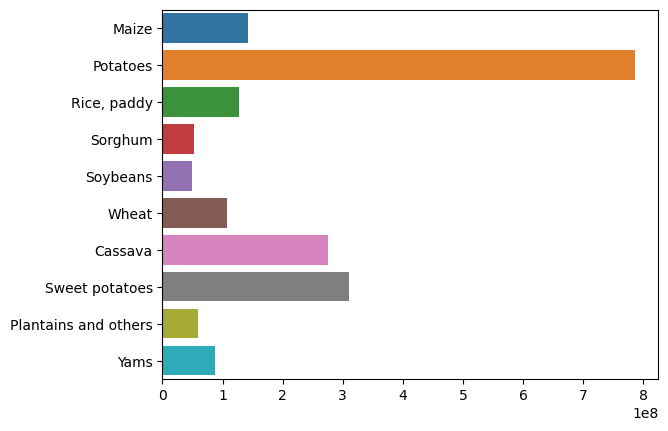

In [37]:
sns.barplot(y=crops,x=yield_per_crop)

Train Test split Rearranging Columns

In [38]:
col = ['Year', 'average_rain_fall_mm_per_year','pesticides_tonnes', 'avg_temp', 'Area', 'Item', 'hg/ha_yield']
df = df[col]
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [39]:
df.head(3)

,Year,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Area,Item,hg/ha_yield
0,1990,1485.0,121.0,16.37,Albania,Maize,36613
1,1990,1485.0,121.0,16.37,Albania,Potatoes,66667
2,1990,1485.0,121.0,16.37,Albania,"Rice, paddy",23333


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

onverting Categorical to Numerical and Scaling the values

In [41]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
ohe = OneHotEncoder(drop='first')
scale = StandardScaler()

preprocesser = ColumnTransformer(
        transformers = [
            ('StandardScale', scale, [0, 1, 2, 3]),
            ('OHE', ohe, [4, 5]),
        ],
        remainder='passthrough'
)

In [42]:
X_train_dummy = preprocesser.fit_transform(X_train)
X_test_dummy = preprocesser.transform(X_test)

In [43]:
preprocesser.get_feature_names_out(col[:-1])

array(['StandardScale__Year',
       'StandardScale__average_rain_fall_mm_per_year',
       'StandardScale__pesticides_tonnes', 'StandardScale__avg_temp',
       'OHE__Area_Algeria', 'OHE__Area_Angola', 'OHE__Area_Argentina',
       'OHE__Area_Armenia', 'OHE__Area_Australia', 'OHE__Area_Austria',
       'OHE__Area_Azerbaijan', 'OHE__Area_Bahamas', 'OHE__Area_Bahrain',
       'OHE__Area_Bangladesh', 'OHE__Area_Belarus', 'OHE__Area_Belgium',
       'OHE__Area_Botswana', 'OHE__Area_Brazil', 'OHE__Area_Bulgaria',
       'OHE__Area_Burkina Faso', 'OHE__Area_Burundi',
       'OHE__Area_Cameroon', 'OHE__Area_Canada',
       'OHE__Area_Central African Republic', 'OHE__Area_Chile',
       'OHE__Area_Colombia', 'OHE__Area_Croatia', 'OHE__Area_Denmark',
       'OHE__Area_Dominican Republic', 'OHE__Area_Ecuador',
       'OHE__Area_Egypt', 'OHE__Area_El Salvador', 'OHE__Area_Eritrea',
       'OHE__Area_Estonia', 'OHE__Area_Finland', 'OHE__Area_France',
       'OHE__Area_Germany', 'OHE__Area_Ghana',

Model training

In [44]:
#linear regression
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,r2_score


models = {
    'lr':LinearRegression(),
    'lss':Lasso(),
    'Rid':Ridge(),
    'Dtr':DecisionTreeRegressor()
}
for name, md in models.items():
    md.fit(X_train_dummy,y_train)
    y_pred = md.predict(X_test_dummy)
    
    print(f"{name} : mae : {mean_absolute_error(y_test,y_pred)} score : {r2_score(y_test,y_pred)}")

lr : mae : 29907.480551403176 score : 0.7473120431759993


C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67280771830.03516, tolerance: 14848622817.505228
  model = cd_fast.sparse_enet_coordinate_descent(


lss : mae : 29893.99762450549 score : 0.7473261756207235
Rid : mae : 29863.348315249048 score : 0.7473066942608841
Dtr : mae : 3916.2321187584344 score : 0.9800658913687244


Select model

In [45]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train_dummy,y_train)
dtr.predict(X_test_dummy)

array([35286., 22814., 19295., ..., 11488., 34879., 79048.])

Predictive System

In [46]:
def prediction(Year, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp, Area, Item):
    # Create an array of the input features
    features = np.array([[Year, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp, Area, Item]], dtype=object)

    # Transform the features using the preprocessor
    transformed_features = preprocesser.transform(features)

    # Make the prediction
    predicted_yield = dtr.predict(transformed_features).reshape(1, -1)

    return predicted_yield[0]

Year = 1990
average_rain_fall_mm_per_year =1485.0
pesticides_tonnes = 121.00
avg_temp = 16.37                   
Area = 'Albania'
Item = 'Maize'
result = prediction(Year, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp, Area, Item)

C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [47]:
result

array([36613.])

In [48]:
import pickle
pickle.dump(dtr,open('dtr.pkl','wb'))
pickle.dump(preprocesser,open('preprocessor.pkl','wb'))

In [49]:
import sklearn
print(sklearn.__version__)

1.2.2
